In [2]:

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
from tigramite.models import LinearMediation, Prediction
from scipy import signal

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/tianyl/opt/anaconda3/lib/python3.9/site-packages/tigramite/data_processing.py:1133: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _get_patterns(array, array_mask, patt, patt_mask, weights, dim, step, fac, N, T):
/Users/tianyl/opt/anaconda3/lib/python3.9/site-packages/tigramite/plotting.py:26: UserWarning: [Errno 2] No such file or directory: '/Users/tianyl/opt/anaconda3/lib/python3.9/site-packages/tigramite/../versions.py'
  warnings.warn(str(e))
/Users/tianyl/opt/anaconda3/lib/python3.9/site-packages/tigramite/independence_tests/gpdc.py:27: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/Users/tianyl/opt/anaconda3/lib/python3.9/site-packages/tigrami

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import copy
from netCDF4 import Dataset, num2date, date2num
import more_itertools as mit
from scipy import arange, cos, exp
from scipy.interpolate import RegularGridInterpolator
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn import metrics
from matplotlib import pyplot
import matplotlib.patches as patches
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

import xarray as xr
import seaborn as sns

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator


from matplotlib import colors as c
import matplotlib.patches as mpatches
from tslearn.utils import to_time_series_dataset
import cartopy.feature as cf
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl


from scipy.stats import rankdata
# Global Spatial Autocorrelation
#from spatial_autocorrelation import get_moransI, moransI_scatterplot, hypothesis_testing
# Local Spatial Autocorrelation
#from spatial_autocorrelation import get_localMoransI, LISA_scatterplot
from scipy.stats import linregress
import scipy
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import random

# land mask, time and spatial information

In [6]:
NCname = r'/Users/tianyl/Desktop/Study/4_summer school in como/CEU_CEN_data/ERA5_Z500_6h_1979-2020_daymean_del29feb_1x1_5days.nc'
NCData = Dataset(NCname)
#t2m = NCData.variables['t2m'][:]
#t2m[t2m==-32767.] = np.nan
print(NCData.variables['lon'][:][:10])
time = NCData.variables['time']
dates = list(num2date(time[:], time.units, time.calendar))
year_era5_all = np.array([date.year for date in dates])
mon_era5_all = np.array([date.month for date in dates])
day_era5_all = np.array([date.day for date in dates])
NCData.close()

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [7]:
def remove_seasonal(var,yearN,stepN):
    var_detrend = np.zeros_like(var)
    for i_box in range(stepN):
        temp = np.array([var[stepN*i_year+i_box] for i_year in range(yearN)])
        temp = temp - np.array(len(temp)*[np.nanmean(temp,axis=0)])
        temp = signal.detrend(temp,axis=0)
        for i_year in range(yearN):
            var_detrend[stepN*i_year+i_box]  = temp[i_year]
    return var_detrend 

In [8]:
def remove_seasonal_normalized(var,yearN,stepN):
    var_detrend = np.zeros_like(var)
    for i_box in range(stepN):
        temp = np.array([var[stepN*i_year+i_box] for i_year in range(yearN)])
        temp = (temp - np.array(len(temp)*[np.nanmean(temp,axis=0)]))/np.array(len(temp)*[np.nanstd(temp,axis=0)])
        temp = signal.detrend(temp,axis=0)
        for i_year in range(yearN):
            var_detrend[stepN*i_year+i_box]  = temp[i_year]
    return var_detrend 

# Central europe region

In [9]:
stepN = len(year_era5_all[year_era5_all==1979])
yearN = 42

In [10]:
lb_EU = 3
rb_EU = 18
bb_EU = 45
tb_EU = 55

# variables

In [11]:
t2m_region_o = np.array(xr.open_dataset('/Users/tianyl/Desktop/Study/4_summer school in como/CEU_CEN_data/t2m_region.nc')['__xarray_dataarray_variable__'][:][:])
tp_region_o = np.array(xr.open_dataset('/Users/tianyl/Desktop/Study/4_summer school in como/CEU_CEN_data/tp_region.nc')['__xarray_dataarray_variable__'][:][:])
PET_region_o = np.array(xr.open_dataset('/Users/tianyl/Desktop/Study/4_summer school in como/CEU_CEN_data/PET_region.nc')['__xarray_dataarray_variable__'][:][:])
WSD_region_o = tp_region_o*1000*24-PET_region_o

z500_T_o = np.array(xr.open_dataset('/Users/tianyl/Desktop/Study/4_summer school in como/CEU_CEN_data/z500_T2m_6Waves.nc')['__xarray_dataarray_variable__'][:][:])
z500_WSD_o = np.array(xr.open_dataset('/Users/tianyl/Desktop/Study/4_summer school in como/CEU_CEN_data/z500_WSD_6Waves.nc')['__xarray_dataarray_variable__'][:][:])
z500_c_o = np.array(xr.open_dataset('/Users/tianyl/Desktop/Study/4_summer school in como/CEU_CEN_data/z500_compound.nc')['__xarray_dataarray_variable__'][:][:])


In [12]:
print('start week ',np.where((year_era5_all==1979)&(mon_era5_all==6))[0][0])
print('time_cycle ',len(np.where((year_era5_all==1979))[0]))
print('n_steps ',len(np.where((year_era5_all==1979)&(np.in1d(mon_era5_all,[6,7,8])))[0]))

start week  30
time_cycle  73
n_steps  19


In [13]:
n_years_all = 42
time_cycle = 73
n_steps =  19
start_week = 30 # 

n_years = n_years_all 
n_links = 4
n_lags = 4 # lags (0 to -3)

tau_min = 1
tau_max = 3
alpha_level_v = 0.05

In [14]:
t2m_region_de = copy.deepcopy(remove_seasonal(t2m_region_o,yearN,stepN))
WSD_region_de = copy.deepcopy(remove_seasonal(tp_region_o*1000*24-PET_region_o,yearN,stepN))
HSI_de1 = copy.deepcopy(t2m_region_de)
SM_de1 = copy.deepcopy(WSD_region_de)

In [15]:
def calculate_ROC_scores(Y_pred_validation,AIR_rain_validation,threshold,mode):

    # calculate ROC scores
    P_index = np.copy(AIR_rain_validation)
    # Test ROC-score			
    TP_rate = []
    FP_rate =  []
    #TP_rate.append(0)
    #FP_rate.append(0)
    #twice for 10th lowest and 90th highet events
    #fixed_event_threshold = np.percentile(P_index, threshold)
    fixed_event_threshold = threshold
    #print(fixed_event_threshold)

    if mode ==1:
        events = np.where(P_index > fixed_event_threshold)[0][:]  # 10% weakest ISM months
        not_events = np.where(P_index <= fixed_event_threshold)[0][:]
        for p in np.linspace(0, 10, 1000):	
            
            #p_pred = numpy.percentile(Y_pred_validation, p*10)
            p_pred = np.percentile(Y_pred_validation, p*10)
            positives_pred = np.where(Y_pred_validation > p_pred)[0][:]
            negatives_pred = np.where(Y_pred_validation <= p_pred)[0][:]


            True_pos = [a for a in positives_pred if a in events]
            False_neg = [a for a in negatives_pred if a in events]
            False_pos = [a for a in positives_pred if a  in not_events]
            True_neg = [a for a in negatives_pred if a  in not_events]
            #check
            if len(True_pos+False_neg) != len(events) :
                print("check 136")
            elif len(True_neg+False_pos) != len(not_events) :
                print("check 138")
            True_pos_rate = len(True_pos)/(float(len(True_pos)) + float(len(False_neg)))
            False_pos_rate = len(False_pos)/(float(len(False_pos)) + float(len(True_neg)))
            FP_rate.append( False_pos_rate)
            TP_rate.append( True_pos_rate)
    if mode==0:
        events = np.where(P_index < fixed_event_threshold)[0][:]  # 10% weakest ISM months
        not_events = np.where(P_index >= fixed_event_threshold)[0][:]
        for p in np.linspace(0, 10, 1000):	
            
            #p_pred = numpy.percentile(Y_pred_validation, p*10)
            p_pred = np.percentile(Y_pred_validation, p*10)
            positives_pred = np.where(Y_pred_validation < p_pred)[0][:]
            negatives_pred = np.where(Y_pred_validation >= p_pred)[0][:]


            True_pos = [a for a in positives_pred if a in events]
            False_neg = [a for a in negatives_pred if a in events]
            False_pos = [a for a in positives_pred if a  in not_events]
            True_neg = [a for a in negatives_pred if a  in not_events]
            #check
            if len(True_pos+False_neg) != len(events) :
                print("check 136")
            elif len(True_neg+False_pos) != len(not_events) :
                print("check 138")
            True_pos_rate = len(True_pos)/(float(len(True_pos)) + float(len(False_neg)))
            False_pos_rate = len(False_pos)/(float(len(False_pos)) + float(len(True_neg)))
            FP_rate.append( False_pos_rate)
            TP_rate.append( True_pos_rate)               
        #print (10*p,p_pred,False_pos_rate, True_pos_rate)
    # plot

    # plt.plot(FP_rate, TP_rate, ls = '--', marker ='.', markersize = 8)
    # plt.xlim(0, 1)
    # plt.xlabel('False positive rate')
    # plt.ylabel('True positive rate')
    ROC_score = np.abs(np.trapz(TP_rate, FP_rate))
    #print(ROC_score )
    return TP_rate, FP_rate,ROC_score

# WSD

In [16]:
per1=95
per2=5
threshold_HSI  =  np.nanpercentile(HSI_de1[np.in1d(mon_era5_all,[6,7,8])],per1)
threshold_SM  =  np.nanpercentile(SM_de1[np.in1d(mon_era5_all,[6,7,8])],per2)

In [19]:

indices_len = 795
train_set_index_all = []
test_set_index_all = []
indices_now = range(indices_len)

test_set_index = random.sample(indices_now,int(0.2*indices_len))
train_set_index = [item for i, item in enumerate(np.arange(indices_len)) if i not in test_set_index]

test_set_index_all.append(test_set_index)
train_set_index_all.append(train_set_index)
indices_now = [i for i in indices_now if i not in test_set_index]

for i in range(4):
    test_set_index = random.sample(indices_now,int(0.2*indices_len))
    train_set_index = [item for i, item in enumerate(np.arange(indices_len)) if i not in test_set_index]

    test_set_index_all.append(test_set_index)
    train_set_index_all.append(train_set_index)
    indices_now = [i for i in indices_now if i not in test_set_index]



In [22]:
AUC_wsd_threshold0 = []
AUC_wsd_threshold1 = []
AUC_wsd_threshold2 = []
AUC_wsd_threshold3 = []
AUC_wsd_threshold4 = []
AUC_wsd_threshold5 = []
AUC_wsd_threshold6 = []
for per1,per2 in zip(np.arange(95,5,-5),np.arange(5,95,5)):

    threshold_HSI  =  np.nanpercentile(HSI_de1[np.in1d(mon_era5_all,[6,7,8])],per1)
    threshold_SM  =  np.nanpercentile(SM_de1[np.in1d(mon_era5_all,[6,7,8])],per2)
    pattern_name = '_6Waves'
    z500_T = np.array(xr.open_dataset('/Users/tianyl/Desktop/Study/4_summer school in como/CEU_CEN_data/z500_T2m'+pattern_name+'.nc')['__xarray_dataarray_variable__'][:][:])
    z500_WSD = np.array(xr.open_dataset('//Users/tianyl/Desktop/Study/4_summer school in como/CEU_CEN_data/z500_WSD'+pattern_name+'.nc')['__xarray_dataarray_variable__'][:][:])
    z500_T_de = copy.deepcopy(remove_seasonal(z500_T,yearN,stepN))
    z500_WSD_de = copy.deepcopy(remove_seasonal(z500_WSD,yearN,stepN))
    iii = 42
    year_number = '_'+str(iii)+'Years'


    index_days = np.where((np.in1d(mon_era5_all,[6,7,8])))[0]
 
    
    fulldata =np.vstack( ( z500_T_de/np.std(z500_T_de),t2m_region_de/np.std(t2m_region_de), z500_WSD_de/np.std(z500_WSD_de), WSD_region_de/np.std(WSD_region_de) )).T[index_days]
    var_names =  [ 'z500_T2m', 'T2m' , 'z500_WSD', 'SM']

    WSD_all1 = copy.deepcopy(WSD_region_de)[index_days]
    t_all1 = copy.deepcopy(t2m_region_de)[index_days]

    z_t_all = fulldata[:,0]
    z_wsd_all = fulldata[:,2]
    t_all = fulldata[:,1]
    wsd_all = fulldata[:,3]

    z_t_mean = np.nanmean(fulldata[:,0])
    z_wsd_mean = np.nanmean(fulldata[:,2])
    t_mean = np.nanmean(fulldata[:,1])
    wsd_mean = np.nanmean(fulldata[:,3])

    AUC_all = []
    for train_set_index, test_set_index in zip(train_set_index_all, test_set_index_all):
        X0 = np.array([np.array(z_wsd_all)]).T[:-1]
        y0 = np.array(wsd_all[1:])
        threshold_per2 = np.percentile(y0, per2)
        reg = LinearRegression().fit(X0[train_set_index], y0[train_set_index])
        k1 = reg.coef_
        y1 =(k1*(z_wsd_all) +reg.intercept_)[:-1]
        index_0=np.where((~np.isnan(y0[test_set_index]))&(~np.isnan(y1[test_set_index])))[0]
        y0 = y0[test_set_index][index_0]
        y1 = y1[test_set_index][index_0]
        y00=np.zeros_like(WSD_all1[test_set_index][index_0])+1
        y00[WSD_all1[test_set_index][index_0]<threshold_SM]=0
        print ('wsd=',k1,'z-1','AUC=')
        if per2>50:
            mode=1
        else:
            mode=0
        AUC_temp = calculate_ROC_scores(y1, y0,threshold_per2,mode)[2]
        AUC_all.append(AUC_temp)
    AUC_wsd_threshold0.append(np.nanmean(AUC_all,axis=0))

    AUC_all = []
    for train_set_index, test_set_index in zip(train_set_index_all, test_set_index_all):
        X0 = np.array([np.array(t_all)]).T[:-1]
        y0 = np.array(wsd_all[1:])
        threshold_per2 = np.percentile(y0, per2)
        reg = LinearRegression().fit(X0[train_set_index], y0[train_set_index])
        k2 = reg.coef_
        y1 =(k2*(t_all)  +reg.intercept_)[:-1]

        index_0=np.where((~np.isnan(y0[test_set_index]))&(~np.isnan(y1[test_set_index])))[0]
        y0 = y0[test_set_index][index_0]
        y1 = y1[test_set_index][index_0]
        y00=np.zeros_like(WSD_all1[test_set_index][index_0])+1
        y00[WSD_all1[test_set_index][index_0]<threshold_SM]=0
        print ('wsd=',k2,'t-1','AUC=')
        AUC_temp = calculate_ROC_scores(y1, y0,threshold_per2,mode)[2]
        AUC_all.append(AUC_temp)
    AUC_wsd_threshold1.append(np.nanmean(AUC_all,axis=0))


    AUC_all = []
    for train_set_index, test_set_index in zip(train_set_index_all, test_set_index_all):
        X0 = np.array([np.array(wsd_all)]).T[:-1]
        y0 = np.array(wsd_all[1:])
        threshold_per2 = np.percentile(y0, per2)
        reg = LinearRegression().fit(X0[train_set_index], y0[train_set_index])
        k3 = reg.coef_
        y1 =(k3*(wsd_all) +reg.intercept_)[:-1]
        index_0=np.where((~np.isnan(y0[test_set_index]))&(~np.isnan(y1[test_set_index])))[0]
        y0 = y0[test_set_index][index_0]
        y1 = y1[test_set_index][index_0]
        y00=np.zeros_like(WSD_all1[test_set_index][index_0])+1
        y00[WSD_all1[test_set_index][index_0]<threshold_SM]=0
        print ('wsd=',k3,'wsd-1','AUC=')
        AUC_temp = calculate_ROC_scores(y1, y0,threshold_per2,mode)[2]
        AUC_all.append(AUC_temp)
    AUC_wsd_threshold2.append(np.nanmean(AUC_all,axis=0))


    AUC_all = []
    for train_set_index, test_set_index in zip(train_set_index_all, test_set_index_all):
        X0 = np.array([np.array(z_wsd_all),np.array(t_all)]).T[:-1]
        y0 = np.array(wsd_all[1:])
        threshold_per2 = np.percentile(y0, per2)
        reg = LinearRegression().fit(X0[train_set_index], y0[train_set_index])
        k1,k2 = reg.coef_
        y1 =(k1*(z_wsd_all)+ k2*(t_all)  +reg.intercept_)[:-1]
        index_0=np.where((~np.isnan(y0[test_set_index]))&(~np.isnan(y1[test_set_index])))[0]
        y0 = y0[test_set_index][index_0]
        y1 = y1[test_set_index][index_0]
        y00=np.zeros_like(WSD_all1[test_set_index][index_0])+1
        y00[WSD_all1[test_set_index][index_0]<threshold_SM]=0
        print ('wsd=',k1,'z-1',k2,'t-1','AUC=')
        AUC_temp = calculate_ROC_scores(y1, y0,threshold_per2,mode)[2]
        AUC_all.append(AUC_temp)
    AUC_wsd_threshold3.append(np.nanmean(AUC_all,axis=0))


    AUC_all = []
    for train_set_index, test_set_index in zip(train_set_index_all, test_set_index_all):
        X0 = np.array([np.array(z_wsd_all),np.array(wsd_all)]).T[:-1]
        y0 = np.array(wsd_all[1:])
        threshold_per2 = np.percentile(y0, per2)
        reg = LinearRegression().fit(X0[train_set_index], y0[train_set_index])
        k1,k3 = reg.coef_
        y1 =(k1*(z_wsd_all)+  k3*(wsd_all) +reg.intercept_)[:-1]
        index_0=np.where((~np.isnan(y0[test_set_index]))&(~np.isnan(y1[test_set_index])))[0]
        y0 = y0[test_set_index][index_0]
        y1 = y1[test_set_index][index_0]
        y00=np.zeros_like(WSD_all1[test_set_index][index_0])+1
        y00[WSD_all1[test_set_index][index_0]<threshold_SM]=0
        print ('wsd=',k1,'z-1',k3,'wsd-1','AUC=')
        AUC_temp = calculate_ROC_scores(y1, y0,threshold_per2,mode)[2]
        AUC_all.append(AUC_temp)
    AUC_wsd_threshold4.append(np.nanmean(AUC_all,axis=0))


    AUC_all = []
    for train_set_index, test_set_index in zip(train_set_index_all, test_set_index_all):
        X0 = np.array([np.array(t_all),np.array(wsd_all)]).T[:-1]
        y0 = np.array(wsd_all[1:])
        threshold_per2 = np.percentile(y0, per2)
        reg = LinearRegression().fit(X0[train_set_index], y0[train_set_index])
        k2,k3 = reg.coef_
        y1 =(k2*(t_all) + k3*(wsd_all) +reg.intercept_)[:-1]
        index_0=np.where((~np.isnan(y0[test_set_index]))&(~np.isnan(y1[test_set_index])))[0]
        y0 = y0[test_set_index][index_0]
        y1 = y1[test_set_index][index_0]
        y00=np.zeros_like(WSD_all1[test_set_index][index_0])+1
        y00[WSD_all1[test_set_index][index_0]<threshold_SM]=0
        print ('wsd=',k2,'t-1',k3,'wsd-1','AUC=')
        AUC_temp = calculate_ROC_scores(y1, y0,threshold_per2,mode)[2]
        AUC_all.append(AUC_temp)
    AUC_wsd_threshold5.append(np.nanmean(AUC_all,axis=0))


    AUC_all = []
    for train_set_index, test_set_index in zip(train_set_index_all, test_set_index_all):
        X0 = np.array([np.array(z_wsd_all),np.array(t_all),np.array(wsd_all)]).T[:-1]
        y0 = np.array(wsd_all[1:])
        threshold_per2 = np.percentile(y0, per2)
        reg = LinearRegression().fit(X0[train_set_index], y0[train_set_index])
        k1,k2,k3 = reg.coef_
        y1 =(k1*(z_wsd_all)+ k2*(t_all) + k3*(wsd_all) +reg.intercept_)[:-1]
        index_0=np.where((~np.isnan(y0[test_set_index]))&(~np.isnan(y1[test_set_index])))[0]
        y0 = y0[test_set_index][index_0]
        y1 = y1[test_set_index][index_0]
        y00=np.zeros_like(WSD_all1[test_set_index][index_0])+1
        y00[WSD_all1[test_set_index][index_0]<threshold_SM]=0
        print ('wsd=',k1,'z-1',k2,'t-1',k3,'wsd-1','AUC=')
        AUC_temp = calculate_ROC_scores(y1, y0,threshold_per2,mode)[2]
        AUC_all.append(AUC_temp)
    AUC_wsd_threshold6.append(np.nanmean(AUC_all,axis=0))



wsd= [-0.38429224] z-1 AUC=
wsd= [-0.44709762] z-1 AUC=
wsd= [-0.4299371] z-1 AUC=
wsd= [-0.40629429] z-1 AUC=
wsd= [-0.3921345] z-1 AUC=
wsd= [-0.13255296] t-1 AUC=
wsd= [-0.1447493] t-1 AUC=
wsd= [-0.1811041] t-1 AUC=
wsd= [-0.12400717] t-1 AUC=
wsd= [-0.09287704] t-1 AUC=
wsd= [0.21531955] wsd-1 AUC=
wsd= [0.26193806] wsd-1 AUC=
wsd= [0.27186528] wsd-1 AUC=
wsd= [0.23111094] wsd-1 AUC=
wsd= [0.24017208] wsd-1 AUC=
wsd= -0.4059532010377878 z-1 0.05443222904169233 t-1 AUC=
wsd= -0.4695154098707478 z-1 0.06325579515809672 t-1 AUC=
wsd= -0.4370719192255225 z-1 0.018663686594307612 t-1 AUC=
wsd= -0.43593602256490926 z-1 0.07185135424423397 t-1 AUC=
wsd= -0.42810607439358583 z-1 0.09428847250155363 t-1 AUC=
wsd= -0.3558512991042149 z-1 0.0471974316701377 wsd-1 AUC=
wsd= -0.40697622042300247 z-1 0.06797186494163335 wsd-1 AUC=
wsd= -0.37933206757746224 z-1 0.08200326777228713 wsd-1 AUC=
wsd= -0.37742123971694314 z-1 0.04560101278538013 wsd-1 AUC=
wsd= -0.3433104516727241 z-1 0.0783492340183

0.7743218090371996


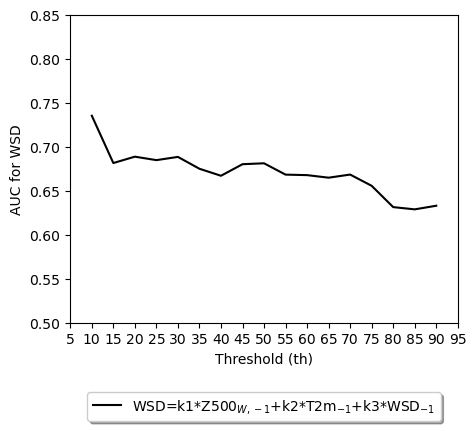

In [24]:
fig = plt.figure(figsize=(5,4))
ax = plt.axes()
#ax.plot(np.arange(5,95,5),AUC_wsd_threshold1,label='Python')
all_labels=['WSD=k1*Z500$_{W,-1}$+k2*T2m$_{-1}$+k3*WSD$_{-1}$']
all_color = ['k']
all_linestyle  = ['-']
for yy,ll,cc,ss in zip([AUC_wsd_threshold6],all_labels,all_color,all_linestyle):
    ax.plot(np.arange(10,95,5),yy[1:],label=ll,color=cc,linestyle=ss)
    print(yy[0])
ax.set_xticks(np.arange(90,5,-5))
ax.set_xlabel('Threshold (th)')
ax.set_ylabel('AUC for WSD')
ax.set_xticks(range(5,100,5))
ax.set_ylim(0.5,0.85)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          ncol=1, fancybox=True, shadow=True)
plt.savefig('AUC_WSD_plot_attribution_part1_test.jpg')

#print ('wsd=',k1,'z-1',k2,'t-1',k3,'wsd-1','AUC=',calculate_ROC_scores(y1, y0,per2,0)[2])

0.7743218090371996
0.7673273326640422
0.6996579087386543
0.5754137903778582


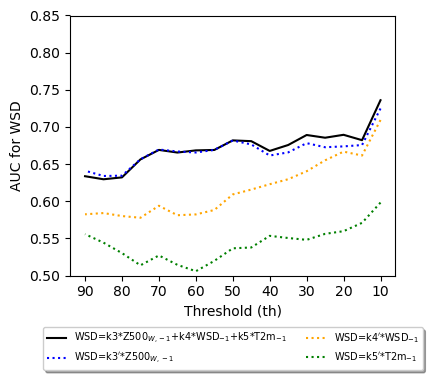

In [35]:
fig = plt.figure(figsize=(5,4))

ax = plt.axes([0.2, 0.3, 0.65, 0.65])
#ax.plot(np.arange(5,95,5),AUC_wsd_threshold1,label='Python')
all_labels=['WSD=k3*Z500$_{W,-1}$+k4*WSD$_{-1}$+k5*T2m$_{-1}$','WSD=k3$^{\prime}$*Z500$_{W,-1}$','WSD=k4$^{\prime}$*WSD$_{-1}$','WSD=k5$^{\prime}$*T2m$_{-1}$','WSD=k3$^{\prime\prime}$*Z500$_{W,-1}$+k4$^{\prime\prime}$*T2m$_{-1}$','WSD=k3$^{\prime\prime}$*Z500$_{W,-1}$+k5$^{\prime\prime}$*WSD$_{-1}$','WSD=k4$^{\prime\prime}$*T2m$_{-1}$+k5$^{\prime\prime}$*WSD$_{-1}$']
all_color = ['k','pink','purple','green','red','blue','orange']
all_linestyle  = ['-',':',':',':','--','--','--']
for yy,ll,cc,ss in zip([AUC_wsd_threshold6,+np.array(AUC_wsd_threshold0),AUC_wsd_threshold2,AUC_wsd_threshold1],all_labels,['k','blue','orange','green'],all_linestyle):
    ax.plot(np.arange(10,95,5),yy[1:],label=ll,color=cc,linestyle=ss)
    print(yy[0])
ax.set_xticks(np.arange(90,5,-5))
ax.set_xlabel('Threshold (th)')
ax.set_ylabel('AUC for WSD')
ax.set_xticks(range(10,100,10))
ax.set_ylim(0.5,0.85)
ax.invert_xaxis()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18),
          ncol=2, fancybox=True, shadow=True,fontsize=7)
fig.savefig('AUC_WSD_plot_attribution_test.jpg',dpi=300)

#print ('wsd=',k1,'z-1',k2,'t-1',k3,'wsd-1','AUC=',calculate_ROC_scores(y1, y0,per2,0)[2])

# T2m

In [31]:
AUC_T2m_threshold0 = []
AUC_T2m_threshold1 = []
AUC_T2m_threshold2 = []
for per1,per2 in zip(np.arange(95,5,-5),np.arange(5,95,5)):
    threshold_HSI  =  np.nanpercentile(HSI_de1[np.in1d(mon_era5_all,[6,7,8])],per1)
    pattern_name = '_6Waves'
    z500_T = np.array(xr.open_dataset(r'/Users/tianyl/Desktop/Study/4_summer school in como/CEU_CEN_data/z500_T2m'+pattern_name+'.nc')['__xarray_dataarray_variable__'][:][:])
    z500_WSD = np.array(xr.open_dataset(r'/Users/tianyl/Desktop/Study/4_summer school in como/CEU_CEN_data/z500_WSD'+pattern_name+'.nc')['__xarray_dataarray_variable__'][:][:])
    z500_T_de = copy.deepcopy(remove_seasonal(z500_T,yearN,stepN))
    z500_WSD_de = copy.deepcopy(remove_seasonal(z500_WSD,yearN,stepN))
    iii = 42
    year_number = '_'+str(iii)+'Years'

    index_days = np.where((np.in1d(mon_era5_all,[6,7,8])))[0]
    fulldata =np.vstack( ( z500_T_de/np.std(z500_T_de),t2m_region_de/np.std(t2m_region_de), z500_WSD_de/np.std(z500_WSD_de), WSD_region_de/np.std(WSD_region_de) )).T[index_days]
    var_names =  [ 'z500_T2m', 'T2m' , 'z500_WSD', 'SM']

    WSD_all1 = copy.deepcopy(WSD_region_de)[index_days]
    t_all1 = copy.deepcopy(t2m_region_de)[index_days]

    z_t_all = fulldata[:,0]
    z_wsd_all = fulldata[:,2]
    t_all = fulldata[:,1]
    wsd_all = fulldata[:,3]

    z_t_mean = np.nanmean(fulldata[:,0])
    z_wsd_mean = np.nanmean(fulldata[:,2])
    t_mean = np.nanmean(fulldata[:,1])
    wsd_mean = np.nanmean(fulldata[:,3])

    AUC_all = []
    for train_set_index, test_set_index in zip(train_set_index_all, test_set_index_all):
        X0 = np.array([np.array(z_t_all)]).T[:-1]
        z0 = np.array(t_all[1:])
        threshold_per1 = np.percentile(z0, per1)
        reg = LinearRegression().fit(X0[train_set_index], z0[train_set_index])
        k4 = reg.coef_
        z1 = (k4*(z_t_all)+reg.intercept_)[:-1]
        index_0=np.where((~np.isnan(z0[test_set_index]))&(~np.isnan(z1[test_set_index])))[0]
        z0 = z0[test_set_index][index_0]
        z1 = z1[test_set_index][index_0]

        z00=np.zeros_like(t_all1[test_set_index][index_0])+0
        z00[t_all1[test_set_index][index_0]>threshold_HSI]=1
        if per1>50:
            mode = 1
        else:
            mode=0
        AUC_temp = calculate_ROC_scores(z1, z0,threshold_per1,mode)[2]
        AUC_all.append(AUC_temp)
    AUC_T2m_threshold1.append(np.nanmean(AUC_all,axis=0))


    AUC_all = []
    for train_set_index, test_set_index in zip(train_set_index_all, test_set_index_all):
        X0 = np.array([np.array(wsd_all)]).T[:-1]
        z0 = np.array(t_all[1:])
        threshold_per1 = np.percentile(z0, per1)
        reg = LinearRegression().fit(X0[train_set_index], z0[train_set_index])
        k5 = reg.coef_
        z1 = ( k5*(wsd_all)+reg.intercept_)[:-1]
        index_0=np.where((~np.isnan(z0[test_set_index]))&(~np.isnan(z1[test_set_index])))[0]
        z0 = z0[test_set_index][index_0]
        z1 = z1[test_set_index][index_0]

        z00=np.zeros_like(t_all1[test_set_index][index_0])+0
        z00[t_all1[test_set_index][index_0]>threshold_HSI]=1
        AUC_temp = calculate_ROC_scores(z1, z0,threshold_per1,mode)[2]
        AUC_all.append(AUC_temp)
    AUC_T2m_threshold2.append(np.nanmean(AUC_all,axis=0))

    AUC_all = []
    for train_set_index, test_set_index in zip(train_set_index_all, test_set_index_all):
        X0 = np.array([np.array(z_t_all),np.array(wsd_all)]).T[:-1]
        z0 = np.array(t_all[1:])
        threshold_per1 = np.percentile(z0, per1)
        reg = LinearRegression().fit(X0[train_set_index], z0[train_set_index])
        k4,k5 = reg.coef_
        z1 = (k4*(z_t_all)+ k5*(wsd_all)+reg.intercept_)[:-1]
        index_0=np.where((~np.isnan(z0[test_set_index]))&(~np.isnan(z1[test_set_index])))[0]
        z0 = z0[test_set_index][index_0]
        z1 = z1[test_set_index][index_0]

        z00=np.zeros_like(t_all1[test_set_index][index_0])+0
        z00[t_all1[test_set_index][index_0]>threshold_HSI]=1
        AUC_temp = calculate_ROC_scores(z1, z0,threshold_per1,mode)[2]
        AUC_all.append(AUC_temp)
    AUC_T2m_threshold0.append(np.nanmean(AUC_all,axis=0))


In [52]:
print(np.nanmin(AUC_T2m_threshold1[1:]),np.nanmax(AUC_T2m_threshold1[1:]))

0.7028541221146954 0.7741541317144612


In [53]:
print(np.nanmin(AUC_T2m_threshold2[1:]),np.nanmax(AUC_T2m_threshold2[1:]))

0.6820134150121004 0.7421744137133194


In [54]:
print(np.nanmin(AUC_T2m_threshold0[1:]),np.nanmax(AUC_T2m_threshold0[1:]))

0.7285021374125678 0.800315151308709


0.8282444360451509
0.8171095732927969
0.7385710712716343


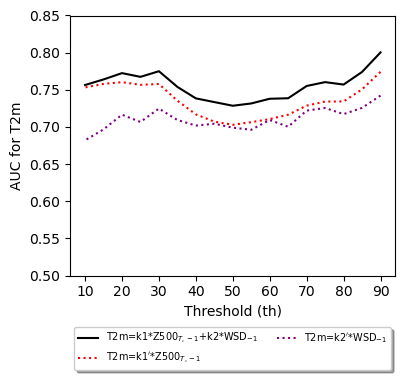

In [47]:
fig = plt.figure(figsize=(5,4))

ax = plt.axes([0.2, 0.3, 0.65, 0.65])
#ax.plot(np.arange(5,95,5),AUC_wsd_threshold1,label='Python')
all_labels=['T2m=k1*Z500$_{T,-1}$+k2*WSD$_{-1}$','T2m=k1$^{\prime}$*Z500$_{T,-1}$','T2m=k2$^{\prime}$*WSD$_{-1}$']
all_color = ['k','red','blue']
all_linestyle  = ['-',':',':',':','--','--','--']
for yy,ll,cc,ss in zip([AUC_T2m_threshold0,AUC_T2m_threshold1,AUC_T2m_threshold2],all_labels,['k','red','purple'],all_linestyle):
    ax.plot(np.arange(90,5,-5),yy[1:],label=ll,color=cc,linestyle=ss)
    print(yy[0])
ax.set_xticks(np.arange(90,5,-5))
ax.set_xlabel('Threshold (th)')
ax.set_ylabel('AUC for T2m')
ax.set_xticks(range(10,100,10))
#ax.invert_xaxis()
ax.set_ylim(0.5,0.85)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18),
          ncol=2, fancybox=True, shadow=True,fontsize=7)
plt.savefig('AUC_T2m_plot_attribution_testing.jpg',dpi=300)

#print ('wsd=',k1,'z-1',k2,'t-1',k3,'wsd-1','AUC=',calculate_ROC_scores(y1, y0,per2,0)[2])

# WSD_compound

In [40]:
AUC_wsd_threshold0_c = []
AUC_wsd_threshold1_c = []
AUC_wsd_threshold2_c = []
AUC_wsd_threshold3_c = []
AUC_wsd_threshold4_c = []
AUC_wsd_threshold5_c = []
AUC_wsd_threshold6_c = []
for per1,per2 in zip(np.arange(95,5,-5),np.arange(5,95,5)):

    threshold_HSI  =  np.nanpercentile(HSI_de1[np.in1d(mon_era5_all,[6,7,8])],per1)
    threshold_SM  =  np.nanpercentile(SM_de1[np.in1d(mon_era5_all,[6,7,8])],per2)
    pattern_name = '_6Waves'

    z500_c = np.array(xr.open_dataset('/Users/tianyl/Desktop/Study/4_summer school in como/CEU_CEN_data/z500_compound.nc')['__xarray_dataarray_variable__'][:][:])
    z500_c_de = copy.deepcopy(remove_seasonal(z500_c,yearN,stepN))

    iii = 42
    year_number = '_'+str(iii)+'Years'


    index_days = np.where((np.in1d(mon_era5_all,[6,7,8])))[0]
    fulldata =np.vstack( ( z500_c_de/np.std(z500_c_de),t2m_region_de/np.std(t2m_region_de),  WSD_region_de/np.std(WSD_region_de) )).T[index_days]
    var_names =  [ 'z500_c', 'T2m' , 'SM']

    WSD_all1 = copy.deepcopy(WSD_region_de)[index_days]
    t_all1 = copy.deepcopy(t2m_region_de)[index_days]

    z_c_all = fulldata[:,0]
    t_all = fulldata[:,1]
    wsd_all = fulldata[:,2]

    z_c_mean = np.nanmean(fulldata[:,0])
    t_mean = np.nanmean(fulldata[:,1])
    wsd_mean = np.nanmean(fulldata[:,2])
    AUC_all = []
    for train_set_index, test_set_index in zip(train_set_index_all, test_set_index_all):
        X0 = np.array([np.array(z_c_all)]).T[:-1]
        y0 = np.array(wsd_all[1:])
        threshold_per2 = np.percentile(y0, per2)
        reg = LinearRegression().fit(X0[train_set_index], y0[train_set_index])
        k1 = reg.coef_
        y1 =(k1*(z_c_all) +reg.intercept_)[:-1]
        index_0=np.where((~np.isnan(y0))&(~np.isnan(y1)))[0]
        y0 = y0[index_0]
        y1 = y1[index_0]
        y00=np.zeros_like(WSD_all1[index_0])+1
        y00[WSD_all1[index_0]<threshold_SM]=0
        print ('wsd=',k1,'z-1','AUC=')
        if per2>50:
            mode=1
        else:
            mode=0
        AUC_temp = calculate_ROC_scores(y1, y0,threshold_per2,mode)[2]
        AUC_all.append(AUC_temp)
    AUC_wsd_threshold0_c.append(np.nanmean(AUC_all,axis=0))

    AUC_all = []
    for train_set_index, test_set_index in zip(train_set_index_all, test_set_index_all):
        X0 = np.array([np.array(t_all)]).T[:-1]
        y0 = np.array(wsd_all[1:])
        threshold_per2 = np.percentile(y0, per2)
        reg = LinearRegression().fit(X0[train_set_index], y0[train_set_index])
        k2 = reg.coef_
        y1 =(k2*(t_all)  +reg.intercept_)[:-1]
        index_0=np.where((~np.isnan(y0[test_set_index]))&(~np.isnan(y1[test_set_index])))[0]
        y0 = y0[test_set_index][index_0]
        y1 = y1[test_set_index][index_0]
        y00=np.zeros_like(WSD_all1[test_set_index][index_0])+1
        y00[WSD_all1[test_set_index][index_0]<threshold_SM]=0
        print ('wsd=',k2,'t-1','AUC=')
        AUC_temp = calculate_ROC_scores(y1, y0,threshold_per2,mode)[2]
        AUC_all.append(AUC_temp)
    AUC_wsd_threshold1_c.append(np.nanmean(AUC_all,axis=0))


    AUC_all = []
    for train_set_index, test_set_index in zip(train_set_index_all, test_set_index_all):
        X0 = np.array([np.array(wsd_all)]).T[:-1]
        y0 = np.array(wsd_all[1:])
        threshold_per2 = np.percentile(y0, per2)
        reg = LinearRegression().fit(X0[train_set_index], y0[train_set_index])
        k3 = reg.coef_
        y1 =(k3*(wsd_all) +reg.intercept_)[:-1]
        index_0=np.where((~np.isnan(y0[test_set_index]))&(~np.isnan(y1[test_set_index])))[0]
        y0 = y0[test_set_index][index_0]
        y1 = y1[test_set_index][index_0]
        y00=np.zeros_like(WSD_all1[test_set_index][index_0])+1
        y00[WSD_all1[test_set_index][index_0]<threshold_SM]=0
        print ('wsd=',k3,'wsd-1','AUC=')
        AUC_temp = calculate_ROC_scores(y1, y0,threshold_per2,mode)[2]
        AUC_all.append(AUC_temp)
    AUC_wsd_threshold2_c.append(np.nanmean(AUC_all,axis=0))

    AUC_all = []
    for train_set_index, test_set_index in zip(train_set_index_all, test_set_index_all):
        X0 = np.array([np.array(z_c_all),np.array(t_all)]).T[:-1]
        y0 = np.array(wsd_all[1:])
        threshold_per2 = np.percentile(y0, per2)
        reg = LinearRegression().fit(X0[train_set_index], y0[train_set_index])
        k1,k2 = reg.coef_
        y1 =(k1*(z_c_all)+ k2*(t_all)  +reg.intercept_)[:-1]
        index_0=np.where((~np.isnan(y0[test_set_index]))&(~np.isnan(y1[test_set_index])))[0]
        y0 = y0[test_set_index][index_0]
        y1 = y1[test_set_index][index_0]
        y00=np.zeros_like(WSD_all1[test_set_index][index_0])+1
        y00[WSD_all1[test_set_index][index_0]<threshold_SM]=0
        print ('wsd=',k1,'z-1',k2,'t-1','AUC=')
        AUC_temp = calculate_ROC_scores(y1, y0,threshold_per2,mode)[2]
        AUC_all.append(AUC_temp)
    AUC_wsd_threshold3_c.append(np.nanmean(AUC_all,axis=0))

    AUC_all = []
    for train_set_index, test_set_index in zip(train_set_index_all, test_set_index_all):
        X0 = np.array([np.array(z_c_all),np.array(wsd_all)]).T[:-1]
        y0 = np.array(wsd_all[1:])
        threshold_per2 = np.percentile(y0, per2)
        reg = LinearRegression().fit(X0[train_set_index], y0[train_set_index])
        k1,k3 = reg.coef_
        y1 =(k1*(z_c_all)+  k3*(wsd_all) +reg.intercept_)[:-1]
        index_0=np.where((~np.isnan(y0[test_set_index]))&(~np.isnan(y1[test_set_index])))[0]
        y0 = y0[test_set_index][index_0]
        y1 = y1[test_set_index][index_0]
        y00=np.zeros_like(WSD_all1[test_set_index][index_0])+1
        y00[WSD_all1[test_set_index][index_0]<threshold_SM]=0
        print ('wsd=',k1,'z-1',k3,'wsd-1','AUC=')
        AUC_temp = calculate_ROC_scores(y1, y0,threshold_per2,mode)[2]
        AUC_all.append(AUC_temp)
    AUC_wsd_threshold4_c.append(np.nanmean(AUC_all,axis=0))

    AUC_all = []
    for train_set_index, test_set_index in zip(train_set_index_all, test_set_index_all):
        X0 = np.array([np.array(t_all),np.array(wsd_all)]).T[:-1]
        y0 = np.array(wsd_all[1:])
        threshold_per2 = np.percentile(y0, per2)
        reg = LinearRegression().fit(X0[train_set_index], y0[train_set_index])
        k2,k3 = reg.coef_
        y1 =(k2*(t_all) + k3*(wsd_all) +reg.intercept_)[:-1]
        index_0=np.where((~np.isnan(y0[test_set_index]))&(~np.isnan(y1[test_set_index])))[0]
        y0 = y0[test_set_index][index_0]
        y1 = y1[test_set_index][index_0]
        y00=np.zeros_like(WSD_all1[test_set_index][index_0])+1
        y00[WSD_all1[test_set_index][index_0]<threshold_SM]=0
        print ('wsd=',k2,'t-1',k3,'wsd-1','AUC=')
        AUC_temp = calculate_ROC_scores(y1, y0,threshold_per2,mode)[2]
        AUC_all.append(AUC_temp)
    AUC_wsd_threshold5_c.append(np.nanmean(AUC_all,axis=0))

    AUC_all = []
    for train_set_index, test_set_index in zip(train_set_index_all, test_set_index_all):
        X0 = np.array([np.array(z_c_all),np.array(t_all),np.array(wsd_all)]).T[:-1]
        y0 = np.array(wsd_all[1:])
        threshold_per2 = np.percentile(y0, per2)
        reg = LinearRegression().fit(X0[train_set_index], y0[train_set_index])
        k1,k2,k3 = reg.coef_
        y1 =(k1*(z_c_all)+ k2*(t_all) + k3*(wsd_all) +reg.intercept_)[:-1]
        index_0=np.where((~np.isnan(y0[test_set_index]))&(~np.isnan(y1[test_set_index])))[0]
        y0 = y0[test_set_index][index_0]
        y1 = y1[test_set_index][index_0]
        y00=np.zeros_like(WSD_all1[test_set_index][index_0])+1
        y00[WSD_all1[test_set_index][index_0]<threshold_SM]=0
        print ('wsd=',k1,'z-1',k2,'t-1',k3,'wsd-1','AUC=')
        AUC_temp = calculate_ROC_scores(y1, y0,threshold_per2,mode)[2]
        AUC_all.append(AUC_temp)
    AUC_wsd_threshold6_c.append(np.nanmean(AUC_all,axis=0))


wsd= [-0.31790145] z-1 AUC=
wsd= [-0.36290885] z-1 AUC=
wsd= [-0.34168226] z-1 AUC=
wsd= [-0.306083] z-1 AUC=
wsd= [-0.3144004] z-1 AUC=
wsd= [-0.13255296] t-1 AUC=
wsd= [-0.1447493] t-1 AUC=
wsd= [-0.1811041] t-1 AUC=
wsd= [-0.12400717] t-1 AUC=
wsd= [-0.09287704] t-1 AUC=
wsd= [0.21531955] wsd-1 AUC=
wsd= [0.26193806] wsd-1 AUC=
wsd= [0.27186528] wsd-1 AUC=
wsd= [0.23111094] wsd-1 AUC=
wsd= [0.24017208] wsd-1 AUC=
wsd= -0.3910990087483427 z-1 0.12550141167846265 t-1 AUC=
wsd= -0.44386737737829157 z-1 0.14526699964399792 t-1 AUC=
wsd= -0.38483617295016254 z-1 0.07528048980406161 t-1 AUC=
wsd= -0.38475272195131477 z-1 0.1335305091581948 t-1 AUC=
wsd= -0.42028568217712914 z-1 0.1828078281031374 t-1 AUC=
wsd= -0.2670610647237186 z-1 0.07321809224974116 wsd-1 AUC=
wsd= -0.28469090054907753 z-1 0.11393975420200936 wsd-1 AUC=
wsd= -0.24669209899653705 z-1 0.134252049314653 wsd-1 AUC=
wsd= -0.23838437247856314 z-1 0.09871793762758517 wsd-1 AUC=
wsd= -0.23090869957608243 z-1 0.116963389050505

0.7163790652726079
0.7313408190224571
0.6996579087386543
0.5754137903778582


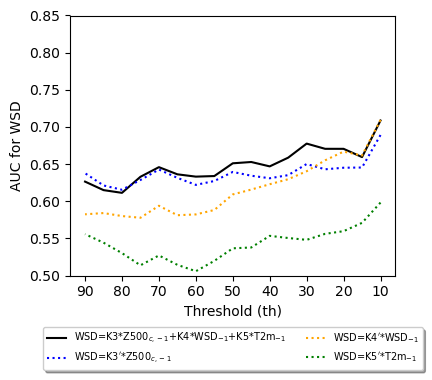

In [55]:
fig = plt.figure(figsize=(5,4))

ax = plt.axes([0.2, 0.3, 0.65, 0.65])
#ax.plot(np.arange(5,95,5),AUC_wsd_threshold1,label='Python')
all_labels=['WSD=K3*Z500$_{c,-1}$+K4*WSD$_{-1}$+K5*T2m$_{-1}$','WSD=K3$^{\prime}$*Z500$_{c,-1}$','WSD=K4$^{\prime}$*WSD$_{-1}$','WSD=K5$^{\prime}$*T2m$_{-1}$','WSD=K3$^{\prime\prime}$*Z500$_{c,-1}$+K4$^{\prime\prime}$*T2m$_{-1}$','WSD=K3$^{\prime\prime}$*Z500$_{c,-1}$+K5$^{\prime\prime}$*WSD$_{-1}$','WSD=K4$^{\prime\prime}$*T2m$_{-1}$+K5$^{\prime\prime}$*WSD$_{-1}$']
all_color = ['k','pink','purple','green','red','blue','orange']
all_linestyle  = ['-',':',':',':','--','--','--']
for yy,ll,cc,ss in zip([AUC_wsd_threshold6_c,np.array(AUC_wsd_threshold0_c),AUC_wsd_threshold2_c,AUC_wsd_threshold1_c],all_labels,['k','blue','orange','green'],all_linestyle):
    ax.plot(np.arange(10,95,5),yy[1:],label=ll,color=cc,linestyle=ss)
    print(yy[0])
ax.set_xticks(np.arange(90,5,-5))
ax.set_xlabel('Threshold (th)')
ax.set_ylabel('AUC for WSD')
ax.invert_xaxis()
ax.set_xticks(range(10,100,10))
ax.set_ylim(0.5,0.85)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18),
          ncol=2, fancybox=True, shadow=True,fontsize=7)
fig.savefig('AUC_WSD_plot_attribution_compound_testing.jpg',dpi=300)

#print ('wsd=',k1,'z-1',k2,'t-1',k3,'wsd-1','AUC=',calculate_ROC_scores(y1, y0,per2,0)[2])

In [57]:
print(np.nanmin(AUC_wsd_threshold0[1:]),np.nanmax(AUC_wsd_threshold0[1:]))

0.6339680040557233 0.7313408190224571


In [58]:
print(np.nanmin(AUC_wsd_threshold2[1:]),np.nanmax(AUC_wsd_threshold2[1:]))

0.5777263411793241 0.7093353855549991


In [59]:
print(np.nanmin(AUC_wsd_threshold1[1:]),np.nanmax(AUC_wsd_threshold1[1:]))

0.5057449846582042 0.5981600415878967


# T2m_compound

In [42]:
AUC_T2m_threshold0_c = []
AUC_T2m_threshold1_c = []
AUC_T2m_threshold2_c = []
for per1,per2 in zip(np.arange(95,5,-5),np.arange(5,95,5)):
    threshold_HSI  =  np.nanpercentile(HSI_de1[np.in1d(mon_era5_all,[6,7,8])],per1)
    pattern_name = '_6Waves'
    z500_c = np.array(xr.open_dataset('/Users/tianyl/Desktop/Study/4_summer school in como/CEU_CEN_data/z500_compound.nc')['__xarray_dataarray_variable__'][:][:])
    z500_c_de = copy.deepcopy(remove_seasonal(z500_c,yearN,stepN))

    iii = 42
    year_number = '_'+str(iii)+'Years'


    index_days = np.where((np.in1d(mon_era5_all,[6,7,8])))[0]
    fulldata =np.vstack( ( z500_c_de/np.std(z500_c_de),t2m_region_de/np.std(t2m_region_de),  WSD_region_de/np.std(WSD_region_de) )).T[index_days]
    var_names =  [ 'z500_c', 'T2m' , 'SM']

    WSD_all1 = copy.deepcopy(WSD_region_de)[index_days]
    t_all1 = copy.deepcopy(t2m_region_de)[index_days]

    z_c_all = fulldata[:,0]
    t_all = fulldata[:,1]
    wsd_all = fulldata[:,2]

    z_c_mean = np.nanmean(fulldata[:,0])
    t_mean = np.nanmean(fulldata[:,1])
    wsd_mean = np.nanmean(fulldata[:,2])


    AUC_all = []
    for train_set_index, test_set_index in zip(train_set_index_all, test_set_index_all):
        X0 = np.array([np.array(z_c_all)]).T[:-1]
        z0 = np.array(t_all[1:])
        threshold_per1 = np.percentile(z0, per1)
        reg = LinearRegression().fit(X0[train_set_index], z0[train_set_index])
        k4 = reg.coef_
        z1 = (k4*(z_c_all)+reg.intercept_)[:-1]
        index_0=np.where((~np.isnan(z0[test_set_index]))&(~np.isnan(z1[test_set_index])))[0]
        z0 = z0[test_set_index][index_0]
        z1 = z1[test_set_index][index_0]

        z00=np.zeros_like(t_all1[test_set_index][index_0])+0
        z00[t_all1[test_set_index][index_0]>threshold_HSI]=1
        if per1>50:
            mode=1
        else:
            mode=0
        AUC_temp = calculate_ROC_scores(z1, z0,threshold_per1,mode)[2]
        AUC_all.append(AUC_temp)
    AUC_T2m_threshold1_c.append(np.nanmean(AUC_all,axis=0))


    AUC_all = []
    for train_set_index, test_set_index in zip(train_set_index_all, test_set_index_all):
        X0 = np.array([np.array(wsd_all)]).T[:-1]
        z0 = np.array(t_all[1:])
        threshold_per1 = np.percentile(z0, per1)
        reg = LinearRegression().fit(X0[train_set_index], z0[train_set_index])
        k5 = reg.coef_
        z1 = ( k5*(wsd_all)+reg.intercept_)[:-1]
        index_0=np.where((~np.isnan(z0[test_set_index]))&(~np.isnan(z1[test_set_index])))[0]
        z0 = z0[test_set_index][index_0]
        z1 = z1[test_set_index][index_0]

        z00=np.zeros_like(t_all1[test_set_index][index_0])+0
        z00[t_all1[test_set_index][index_0]>threshold_HSI]=1
        AUC_temp = calculate_ROC_scores(z1, z0,threshold_per1,mode)[2]
        AUC_all.append(AUC_temp)
    AUC_T2m_threshold2_c.append(np.nanmean(AUC_all,axis=0))

    AUC_all = []
    for train_set_index, test_set_index in zip(train_set_index_all, test_set_index_all):
        X0 = np.array([np.array(z_c_all),np.array(wsd_all)]).T[:-1]
        z0 = np.array(t_all[1:])
        threshold_per1 = np.percentile(z0, per1)
        reg = LinearRegression().fit(X0[train_set_index], z0[train_set_index])
        k4,k5 = reg.coef_
        z1 = (k4*(z_c_all)+ k5*(wsd_all)+reg.intercept_)[:-1]
        index_0=np.where((~np.isnan(z0[test_set_index]))&(~np.isnan(z1[test_set_index])))[0]
        z0 = z0[test_set_index][index_0]
        z1 = z1[test_set_index][index_0]

        z00=np.zeros_like(t_all1[test_set_index][index_0])+0
        z00[t_all1[test_set_index][index_0]>threshold_HSI]=1
        AUC_temp = calculate_ROC_scores(z1, z0,threshold_per1,mode)[2]
        AUC_all.append(AUC_temp)
    AUC_T2m_threshold0_c.append(np.nanmean(AUC_all,axis=0))


0.8081428700056497
0.7957588129643317
0.7385710712716343


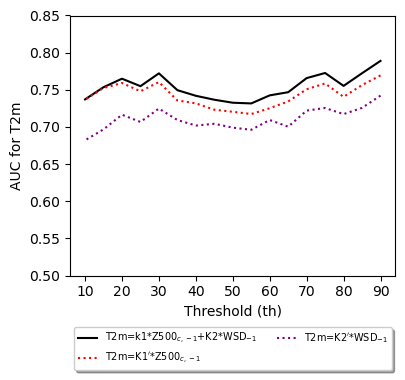

In [48]:
fig = plt.figure(figsize=(5,4))

ax = plt.axes([0.2, 0.3, 0.65, 0.65])
#ax.plot(np.arange(5,95,5),AUC_wsd_threshold1,label='Python')
all_labels=['T2m=k1*Z500$_{c,-1}$+K2*WSD$_{-1}$','T2m=K1$^{\prime}$*Z500$_{c,-1}$','T2m=K2$^{\prime}$*WSD$_{-1}$']
all_color = ['k','red','blue']
all_linestyle  = ['-',':',':',':','--','--','--']
for yy,ll,cc,ss in zip([AUC_T2m_threshold0_c,AUC_T2m_threshold1_c,AUC_T2m_threshold2_c],all_labels,['k','red','purple'],all_linestyle):
    ax.plot(np.arange(90,5,-5),yy[1:],label=ll,color=cc,linestyle=ss)
    print(yy[0])
ax.set_xticks(np.arange(90,5,-10))
ax.set_xlabel('Threshold (th)')
ax.set_ylabel('AUC for T2m')
ax.set_xticks(range(10,100,10))
# ax.invert_xaxis()
ax.set_ylim(0.5,0.85)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18),
          ncol=2, fancybox=True, shadow=True,fontsize=7)
plt.savefig('AUC_T2m_plot_attribution_compound_test.jpg',dpi=300)

#print ('wsd=',k1,'z-1',k2,'t-1',k3,'wsd-1','AUC=',calculate_ROC_scores(y1, y0,per2,0)[2])